<h1>Importing Dependencies</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models,Sequential

from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import precision_score, recall_score

<h1>Loading Data</h1>

In [2]:
images, labels = galaxy10.load_data()

C:\Users\dell\.astroNN\datasets\Galaxy10_DECals.h5 was found!


<h1>Data Preprocessing</h1>

<h4>i. Resising images</h4>

In [3]:
def resize_image(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (64, 64))
        resized_images.append(resized_image)
    
    resized_images = np.array(resized_images)
    return resized_images

<h4>ii. Normalisation</h4>

In [4]:
def normalize_data(x):
    x = np.array(x)
    x_normalized = (x.astype(np.float32) - 127.5)/127.5
    return x_normalized

<h4>ii. Data Preparation</h4>

In [5]:
resized_images = resize_image(images)
normalized_images = normalize_data(resized_images)

<h1>Getting the Minor classes</h1>

In [6]:
def get_labeld_data(feature,images,labels):
    indices = np.where(labels == feature)[0]
    x_train = []
    for i in indices:
        x_train.append(images[i])
    return np.array(x_train)

<h1>Generator Architecture</h1>

In [7]:
def build_generator(latent_dim):
    
    model = keras.Sequential()
    
    model.add(layers.Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((16, 16, 128)))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same'))
    
    return model

<h1>Descriminator Architecture</h1>

In [8]:
def build_discriminator(input_shape,d_rate=0.5):
    
    model = keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(d_rate))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(d_rate))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

<h1>GAN</h1>

In [9]:
def build_gan(generator, discriminator):
    
    discriminator.trainable = False
    model = keras.Sequential()
    
    model.add(generator)
    
    model.add(discriminator)
    
    return model

<h1>Functions from Scratch!</h1>

In [10]:
def extract_features(images, model):
    preprocessed_images = preprocess_input(images)
    features = model.predict(preprocessed_images)
    return features    

In [11]:
def sqrtmm(matrix):
    # Compute the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(matrix)
    # Take the square root of the eigenvalues with regularization
    sqrt_eigvals = np.sqrt(np.maximum(0, eigvals))
    # Reconstruct the square root of the matrix
    sqrt_matrix = eigvecs.dot(np.diag(sqrt_eigvals)).dot(np.linalg.inv(eigvecs))
    return sqrt_matrix

In [12]:
def compute_covariance(act):
    # Compute the mean vector
    mu = np.mean(act, axis=0)
    # Center the data
    centered_data = act - mu
    # Compute the covariance matrix
    cov_matrix = np.dot(centered_data.T, centered_data) / (act.shape[0] - 1)
    return cov_matrix

<h4><i>Fid Score calculation</i></h4>

In [13]:
# Function to compute Frechet Inception Distance (FID)
def calculate_fid(model, real_images, generated_images):
    # Extract features from real and generated images
    real_features = extract_features(real_images, model)
    generated_features = extract_features(generated_images, model)
    
    # Compute covariance matrices
    sigma1 = compute_covariance(real_features)
    sigma2 = compute_covariance(generated_features)
    
    # Add a small epsilon to the diagonal of covariance matrices for regularization
    epsilon = 1e-6
    sigma1 += epsilon * np.eye(sigma1.shape[0])
    sigma2 += epsilon * np.eye(sigma2.shape[0])
    
    # Compute mean vectors
    mu1 = np.mean(real_features, axis=0)
    mu2 = np.mean(generated_features, axis=0)
    
    # Compute squared differences between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    # Compute square root of product of covariance matrices
    covmean = np.real(sqrtmm(sigma1.dot(sigma2)))
    
    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [14]:
def plot_sample_images(images, grid_size=(10, 10), image_size=(64, 64), spacing=0.1):
    n_samples = images.shape[0]
    plt.figure(figsize=(grid_size[0] * 2, grid_size[1] * 2))
    for i in range(n_samples):
        plt.subplot(grid_size[0], grid_size[1], i+1)
        clipped_image = np.clip(images[i], 0, 1)
        plt.imshow(clipped_image, interpolation='nearest')
        plt.axis('off')
        plt.subplots_adjust(wspace=spacing, hspace=spacing)  # Adjust space between subplots
        plt.xticks([]), plt.yticks([])  # Hide ticks
    plt.show()

<h1>Training the GAN</h1>

In [15]:
def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=50, batch_size=32):
    
    batch_count = dataset.shape[0] // batch_size
    
    for epoch in range(n_epochs):
        for batch in range(batch_count):
            # Train discriminator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_images = generator.predict(noise)
            real_images = dataset[np.random.randint(0, dataset.shape[0], batch_size)]
            combined_images = np.concatenate([gen_images, real_images])
            labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)  # Add noise to labels
            discriminator_loss = discriminator.train_on_batch(combined_images, labels)
            
            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            misleading_targets = np.ones((batch_size, 1))
            generator_loss = gan.train_on_batch(noise, misleading_targets)
        
        # Print progress and evaluation metrics
        print(f"Epoch {epoch+1}/{n_epochs}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

<h1>Main Function</h1>

In [16]:
def main(feature,n_samples,images,labels):
    
    x_train = get_labeld_data(feature,images,labels)
    
    latent_dim = 100
    # Load data
    dataset = x_train
    
    # Build and compile the discriminator
    discriminator = build_discriminator(dataset.shape[1:],0.4)
    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    
    # Build the generator
    generator = build_generator(latent_dim)
    
    # Build and compile the GAN
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    
    # Train the GAN
    train_gan(generator, discriminator, gan, dataset, latent_dim)
    
    # Generate some images
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_images = generator.predict(noise)
    plot_sample_images(generated_images[0:10])
    
    new_images = generated_images
    generated_labels = np.full((n_samples,), feature)
    new_dataset = [new_images,generated_labels]
    
    # Save or use the new dataset as needed
    # new_dataset = (new_images, new_labels)
    
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    real_images_resized = tf.image.resize(x_train, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))
    
    print("Evaluation Metrics:")
    fid_score = calculate_fid(inception_model,real_images_resized,generated_images_resized)
    print(f"FID Score: {fid_score}")

    return new_dataset

In [17]:
def best_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    return model

In [39]:
model_basic = best_model()
model_gan = best_model()

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [40]:
# Compile each model with sparse categorical crossentropy loss
model_basic.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gan.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h3>Basic model</h3>

In [18]:
x_train, x_test, y_train, y_test = train_test_split(normalized_images, labels, test_size=0.2,random_state=42)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [43]:
# Fit the model with early stopping
history = model_basic.fit(x_train, y_train, epochs=20, batch_size=32, 
                          validation_data=(x_val, y_val), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - accuracy: 0.1940 - loss: 2.1092 - val_accuracy: 0.4486 - val_loss: 1.4003
Epoch 2/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.4829 - loss: 1.3765 - val_accuracy: 0.6177 - val_loss: 1.0965
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 57s 161ms/step - accuracy: 0.6086 - loss: 1.1252 - val_accuracy: 0.6667 - val_loss: 0.9517
Epoch 4/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - accuracy: 0.6814 - loss: 0.9364 - val_accuracy: 0.6748 - val_loss: 0.9499
Epoch 5/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.7106 - loss: 0.8484 - val_accuracy: 0.6853 - val_loss: 0.9278
Epoch 6/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.7561 - loss: 0.7355 - val_accuracy: 0.7044 - val_loss: 0.9096
Epoch 7/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 77s 217ms/step - accuracy: 0.7943 - loss: 0.6178 - val_accuracy: 0.6991 - val_loss: 0.9451
Epoch 8/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.8116 - loss: 0

In [30]:
model_basic.save("best-model.h5")

In [44]:
test_predictions_basic = model_basic.predict(x_test)
test_predictions_basic = np.argmax(test_predictions_basic, axis=1) 

111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


In [45]:
print(classification_report(y_test, test_predictions_basic))

              precision    recall  f1-score   support

           0       0.66      0.28      0.39       204
           1       0.85      0.68      0.75       373
           2       0.89      0.86      0.87       529
           3       0.71      0.91      0.80       408
           4       0.51      0.39      0.44        71
           5       0.75      0.69      0.72       436
           6       0.62      0.59      0.60       365
           7       0.51      0.70      0.59       516
           8       0.88      0.84      0.86       283
           9       0.85      0.84      0.85       363

    accuracy                           0.73      3548
   macro avg       0.72      0.68      0.69      3548
weighted avg       0.74      0.73      0.72      3548



In [46]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, test_predictions_basic)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 57   3  16  28   4  10   7  67   6   6]
 [  2 253   8  33   4  22   4  36   4   7]
 [  4  11 455   7   0   3  31  18   0   0]
 [  2   5   6 371   2   2   1  17   0   2]
 [  0   0   0  19  28   1   0  10   2  11]
 [  9   6   2  18   0 302  24  72   2   1]
 [  0   2  13   8   2  18 214 103   3   2]
 [  8   7  13  21   1  35  59 359   7   6]
 [  4   4   0   0   4   1   3  10 239  18]
 [  0   7   0  18  10   7   0   6  10 305]]


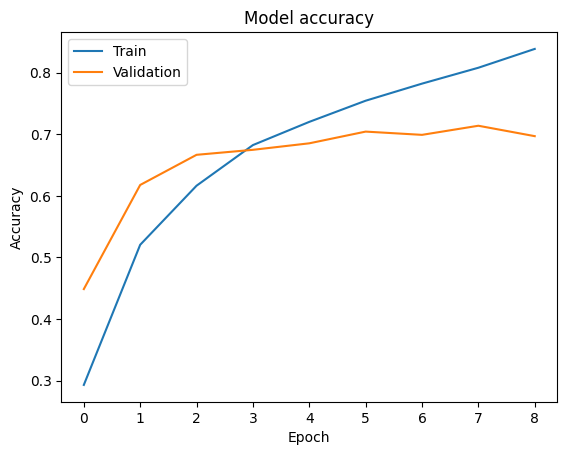

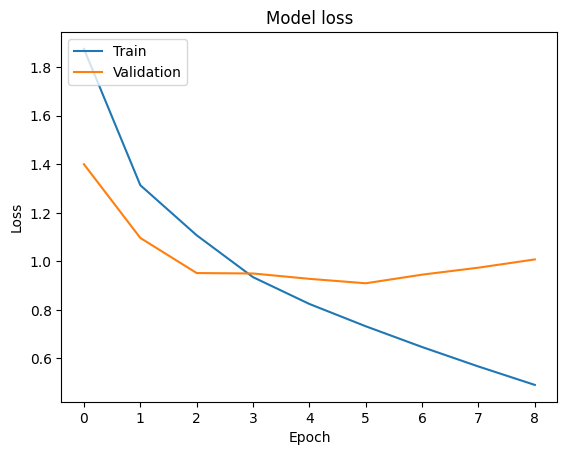

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h3>GAN + Model</h3>

In [21]:
dataset_0 = main(0,200,normalized_images,labels)

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:77: UserWarning: The model does not have any trainable weights.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

DecodeError: Error parsing message

In [17]:
import h5py

# Assuming images_array is your variable containing the images as arrays
with h5py.File('images_00.h5', 'w') as hf:
    hf.create_dataset('images_00', data=dataset_0[0])
with h5py.File('labels_00.h5', 'w') as hf:
    hf.create_dataset('labels_00', data=dataset_0[1])

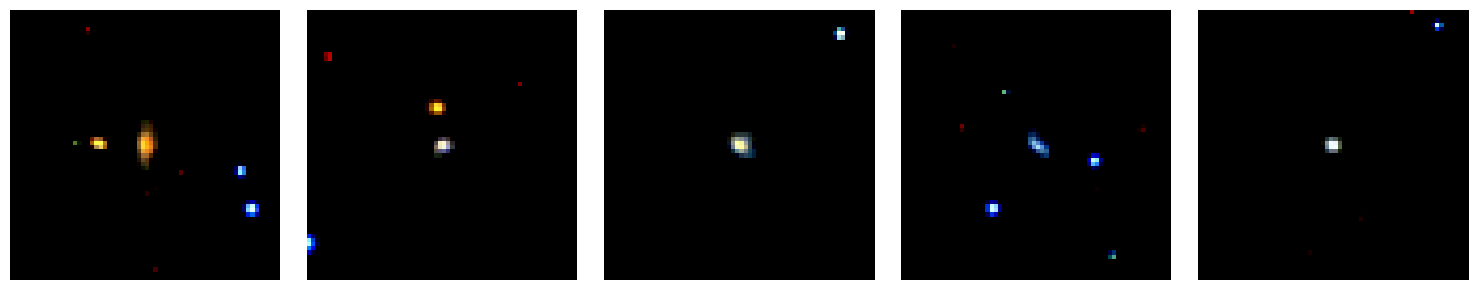

In [18]:
def plot_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Convert pixel values to the valid range [0, 255]
        image = np.clip(images[i] * 255, 0, 255).astype(np.uint8)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have a function get_labeled_data that returns images and labels
images = get_labeld_data(0, normalized_images, labels)

# Plot some of the images
plot_images(images, 5)


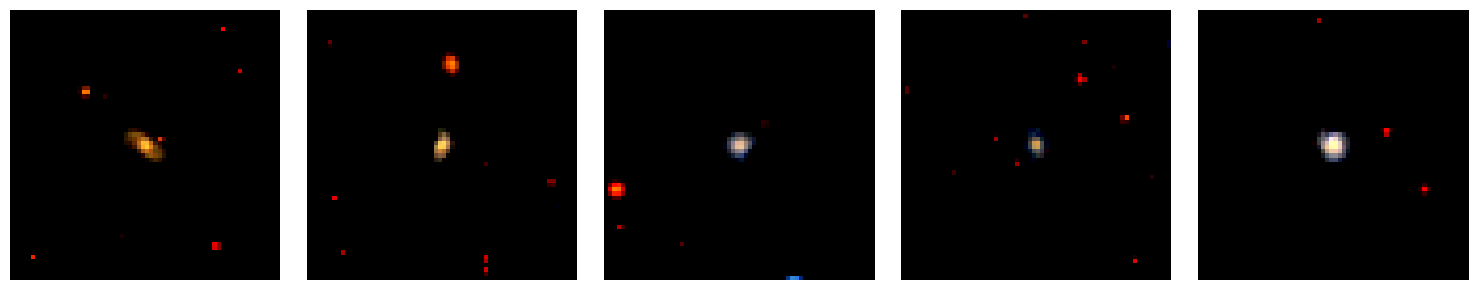

In [19]:
def plot_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Convert pixel values to the valid range [0, 255]
        image = np.clip(images[i] * 255, 0, 255).astype(np.uint8)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have a function get_labeled_data that returns images and labels
images = get_labeld_data(7, normalized_images, labels)

# Plot some of the images
plot_images(images, 5)

1/1 [==============================] - 0s 203ms/step
Epoch 1/100, Discriminator Loss: 0.5044111013412476, Generator Loss: 0.45186102390289307
1/1 [==============================] - 0s 219ms/step
Epoch 2/100, Discriminator Loss: 0.6167711615562439, Generator Loss: 0.6117740273475647
1/1 [==============================] - 0s 219ms/step
Epoch 3/100, Discriminator Loss: 0.5614206790924072, Generator Loss: 0.7900925874710083
1/1 [==============================] - 0s 219ms/step
Epoch 4/100, Discriminator Loss: 0.6033430099487305, Generator Loss: 0.7749918699264526
1/1 [==============================] - 0s 219ms/step
Epoch 5/100, Discriminator Loss: 0.5344067811965942, Generator Loss: 0.7391010522842407
1/1 [==============================] - 0s 219ms/step
Epoch 6/100, Discriminator Loss: 0.5254096984863281, Generator Loss: 0.6684408783912659
1/1 [==============================] - 0s 219ms/step
Epoch 7/100, Discriminator Loss: 0.45897775888442993, Generator Loss: 0.6881942749023438
1/1 [======

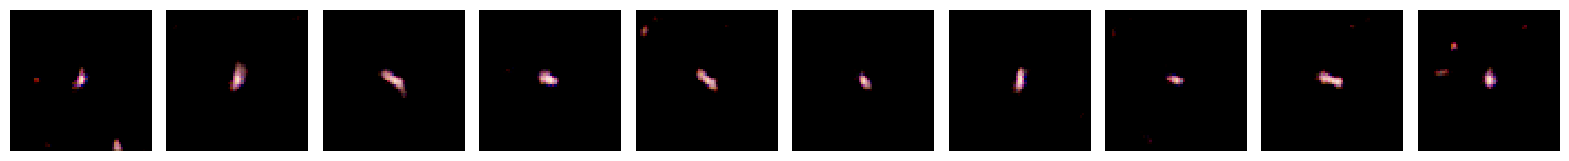

Evaluation Metrics:
47/47 [==============================] - 136s 3s/step
FID Score: 0.8000730276107788


In [29]:
dataset_4 = main(4,1500,normalized_images,labels)

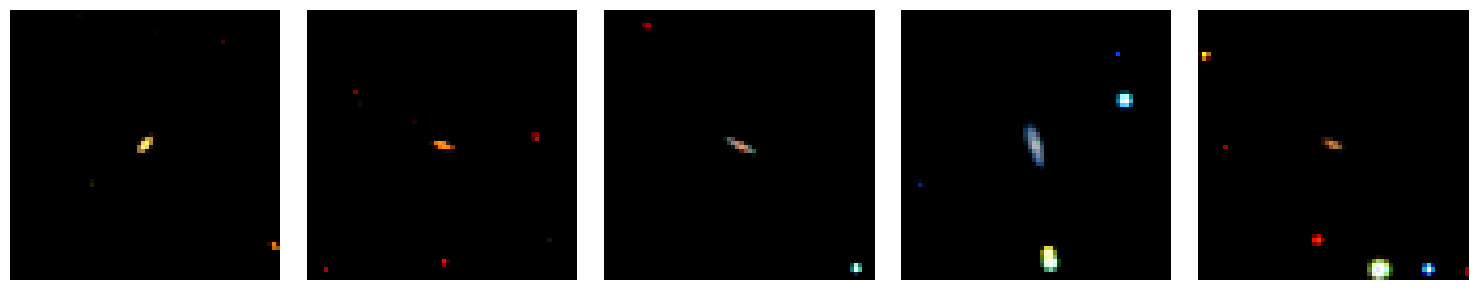

In [78]:
# Assuming you have a function get_labeled_data that returns images and labels
images = get_labeld_data(4, normalized_images, labels)

# Plot some of the images
plot_images(images, 5)


1/1 [==============================] - 0s 234ms/step
Epoch 1/100, Discriminator Loss: 0.4700942039489746, Generator Loss: 0.7671617865562439
1/1 [==============================] - 0s 203ms/step
Epoch 2/100, Discriminator Loss: 0.41672617197036743, Generator Loss: 0.9727433919906616
1/1 [==============================] - 0s 234ms/step
Epoch 3/100, Discriminator Loss: 0.78510582447052, Generator Loss: 0.7156282663345337
1/1 [==============================] - 0s 219ms/step
Epoch 4/100, Discriminator Loss: 0.6235224604606628, Generator Loss: 0.9333251714706421
1/1 [==============================] - 0s 219ms/step
Epoch 5/100, Discriminator Loss: 0.1257176399230957, Generator Loss: 2.7471866607666016
1/1 [==============================] - 0s 238ms/step
Epoch 6/100, Discriminator Loss: 0.6243326663970947, Generator Loss: 1.060049057006836
1/1 [==============================] - 0s 250ms/step
Epoch 7/100, Discriminator Loss: 0.8357219696044922, Generator Loss: 0.7129702568054199
1/1 [==========

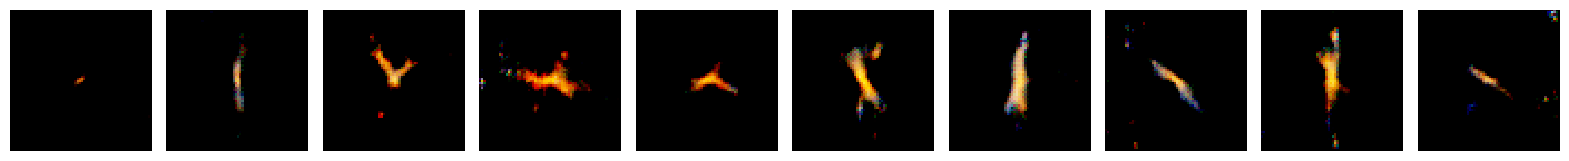

Evaluation Metrics:
13/13 [==============================] - 36s 3s/step
FID Score: 0.5865066051483154


In [30]:
dataset_8 = main(8,400,normalized_images,labels)

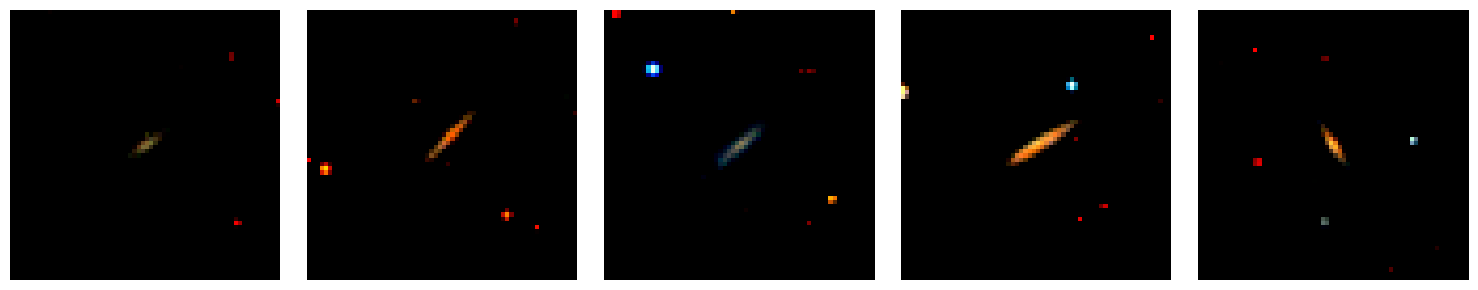

In [79]:
images = get_labeld_data(8, normalized_images, labels)

# Plot some of the images
plot_images(images, 5)


In [55]:
x_train_augmented = np.concatenate((x_train, dataset_0[0], dataset_4[0], dataset_8[0]))
y_train_augmented = np.concatenate((y_train, dataset_0[1], dataset_4[1], dataset_8[1]))

In [34]:
import h5py

# Open the HDF5 file for reading
with h5py.File('images.h5', 'r') as hf:
    # Access the dataset containing the images
    images_array_restored = hf['images'][:]

with h5py.File('images_l.h5', 'r') as hf:
    # Access the dataset containing the images
    labels = hf['images_l'][:]


In [ ]:
# Get the number of samples
num_samples = len(labels)

# Generate a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Shuffle the data using the random indices
x_train_aug_shuffled = images_array_restored[random_indices]
y_train_aug_shuffled = labels[random_indices]

In [ ]:
batch_size = 128 
# Fit the model with early stopping
history_gan = model_gan.fit(x_train_aug_shuffled, y_train_aug_shuffled, epochs=20, batch_size= 128, 
                          validation_data=(x_val, y_val), verbose=1,
                          callbacks=[early_stopping])

In [ ]:
test_predictions_gan = model_gan.predict(x_test)
test_predictions_gan = np.argmax(test_predictions_gan, axis=1)

In [ ]:
print(classification_report(y_test, test_predictions_gan))

In [ ]:
conf_matrix_gan = confusion_matrix(y_test, test_predictions_gan)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_gan)


In [ ]:
plt.plot(history_gan.history['accuracy'])
plt.plot(history_gan.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_gan.history['loss'])
plt.plot(history_gan.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Open the HDF5 file for reading
import h5py
with h5py.File('images_0.h5', 'r') as hf:
    # Access the dataset containing the images
    images0_array_restored = hf['images_0'][:]
    
# Open the HDF5 file for reading
with h5py.File('labels_0.h5', 'r') as hf:
    # Access the dataset containing the images
    labels0_array_restored = hf['labels_0'][:]


In [ ]:
# Open the HDF5 file for reading
with h5py.File('images_00.h5', 'r') as hf:
    # Access the dataset containing the images
    images00_array_restored = hf['images_00'][:]
    
# Open the HDF5 file for reading
with h5py.File('labels_00.h5', 'r') as hf:
    # Access the dataset containing the images
    labels00_array_restored = hf['labels_00'][:]


In [ ]:
x = np.concatenate((x_train,images0_array_restored,images00_array_restored))
y = np.concatenate((y_train,labels0_array_restored,labels00_array_restored))

In [ ]:
# Get the number of samples
num_samples = len(y)

# Generate a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Shuffle the data using the random indices
x_train_augmented_shuffled = x[random_indices]
y_train_augmented_shuffled = y[random_indices]

In [ ]:
model_gan2 = best_model()
model_gan2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32 
# Fit the model with early stopping
history_gan2 = model_gan2.fit(x_train_augmented_shuffled, y_train_augmented_shuffled, epochs=20, batch_size=batch_size, 
                          validation_data=(x_val, y_val), verbose=1,
                          callbacks=[early_stopping])

In [ ]:
test_predictions_gan2 = model_gan2.predict(x_test)
test_predictions_gan2 = np.argmax(test_predictions_gan2, axis=1) 

In [ ]:
print(classification_report(y_test, test_predictions_gan2))

In [ ]:
conf_matrix_gan2 = confusion_matrix(y_test, test_predictions_gan2)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_gan2)

In [ ]:
plt.plot(history_gan2.history['accuracy'])
plt.plot(history_gan2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_gan2.history['loss'])
plt.plot(history_gan2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()